# Загрузка датасета

In [1]:
!mkdir dataset
!mkdir dataset/COCO

mkdir: cannot create directory ‘dataset’: File exists
mkdir: cannot create directory ‘dataset/COCO’: File exists


In [0]:
!wget http://images.cocodataset.org/zips/train2014.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!wget http://images.cocodataset.org/zips/val2014.zip

In [3]:
!unzip -n annotations_trainval2014.zip -d dataset/COCO
!rm annotations_trainval2014.zip
!unzip -n val2014.zip -d dataset/COCO
!rm val2014.zip
!unzip -n train2014.zip -d dataset/COCO
!rm train2014.zip

unzip:  cannot find or open annotations_trainval2014.zip, annotations_trainval2014.zip.zip or annotations_trainval2014.zip.ZIP.
rm: cannot remove 'annotations_trainval2014.zip': No such file or directory
unzip:  cannot find or open val2014.zip, val2014.zip.zip or val2014.zip.ZIP.
rm: cannot remove 'val2014.zip': No such file or directory
Archive:  train2014.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of train2014.zip or
        train2014.zip.zip, and cannot find train2014.zip.ZIP, period.


## Импорты

In [1]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.models.detection as detection
import torch.nn as nn
from torch.utils.data import DataLoader
import torch
import random
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from nltk.tokenize import word_tokenize
import nltk
import string
nltk.download('punkt')
import json
from os.path import exists
import os.path
import torch.optim as optim
torch.cuda.empty_cache()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
from google.colab import drive
# 4/zwHuEupIGt-zZtuqPuTURspnECliT8QgitpalqMCv-B5REKHMdNtM2g
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Обработка датасета

In [3]:
dataset = os.path.abspath(r'/content/dataset/COCO')
transformations = transforms.Compose([
                              transforms.Resize((512,512)),
                              transforms.ToTensor(),
                              transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
train = dset.CocoCaptions(root=dataset + r'/train2014',
                          annFile=dataset + r'/annotations/captions_train2014.json',
                          transform=transformations)

loading annotations into memory...
Done (t=0.60s)
creating index...
index created!


In [4]:
print('Number of samples: ', len(train))
img, target = train[50]  # load 4th sample
t = target[1]

print("Image Size: ", img.size())
print(target)

Number of samples:  82783
Image Size:  torch.Size([3, 512, 512])
['a couple of boats that are in some water', 'A pair of boats docked at a pier is shown.', 'Three boats docked in still water with clouds in the sky. ', 'Three boats are docked together on the cloudy day.', 'some colorful boats sitting next to a dock ']


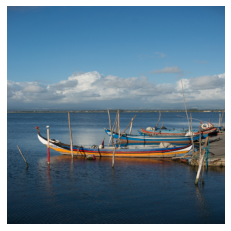

In [5]:
def plot_img(img):
    mean=np.array([0.485, 0.456, 0.406])
    std=np.array([0.229, 0.224, 0.225])
    default_img = np.clip(np.array(img).transpose(1,2,0)*std + mean, 0, 1)
    plt.axis('off')
    plt.imshow(default_img)
plot_img(img)

# Словарь

In [0]:
from collections import defaultdict
from itertools import chain

In [0]:
def tokenize(text):
    return [token for token in word_tokenize(text.lower().translate(str.maketrans('', '', string.punctuation)))]

Выделяю все подписи из датасета. Это все происходит долго, поэтому лучше сохранить выделенные подписи.

In [0]:
def get_all_captions(dataset):
    if exists('captions.json'):
        with open('captions.json', 'r') as f:
            return json.load(f)
    all_captions = []
    d = len(dataset)
    for i, (_, captions) in enumerate(dataset):
        print(f'{i/d*100:.2f}%\r', end='')
        all_captions.extend(captions)
    print()
    return all_captions
        
def tokenize_captions(captions):
    print('Tokenizing...')
    return [tokenize(cap) for cap in captions]

In [0]:
# captions = get_all_captions(train)
# tokens = tokenize_captions(captions)

In [0]:
# with open('captions.json', 'w') as f:
    # json.dump(captions, f)

Строю `defaultdict`, чтобы неизвестные слова автоматически переводились в `<UNK>`.

In [0]:
def build_dict(tokens, special_tokens, tok2idx=None, idx2tok=None):
    """
        tokens: a list of lists of tokens
        special_tokens: some special tokens
    """
    if tok2idx is None or idx2tok is None:
        tok2idx = defaultdict(lambda: 0)
        idx2tok = []
    
    for t in chain(special_tokens, *tokens):
        if t not in tok2idx:
            tok2idx[t] = len(idx2tok)
            idx2tok.append(t)
    
    return tok2idx, idx2tok

def build_dict_from(path):
    with open(path, 'r') as f:
        idx2tok = json.load(f)
    tok2idx = defaultdict(lambda: 0, [(t, i) for i, t in enumerate(idx2tok)])
    return tok2idx, idx2tok

In [0]:
special_tokens = ['<UNK>', '<PAD>', '<START>', '<END>']
# token2idx, idx2token = build_dict(tokens, special_tokens)
token2idx, idx2token = build_dict_from('idx2token.json')

In [13]:
len(idx2token)

24782

In [0]:
# with open('idx2token.json', 'w') as f:
#     json.dump(idx2token, f)

In [0]:
def words2idxs(tokens_list):
    return [token2idx[word] for word in tokens_list]

def idxs2words(idxs):
    return [idx2token[idx] for idx in idxs]

# Нормальная загрузка датасета

Функция для перевода подписи в индексы словаря. Также добавляются специальные токены `<START>`, `<END>` и токены паддинга `<PAD>`. Все выходные подписи становятся длины `seq_length`.

In [0]:
def to_indxs(caption, seq_length=20):
    c = ['<START>'] + tokenize(caption) + ['<END>']
    if len(c) > seq_length:
        c = c[:seq_length]
        c[-1] = '<END>'
    else:
        c += ['<PAD>'] * (seq_length - len(c))
    return words2idxs(c)

def target_transform(captions, seq_length=20):
    return [to_indxs(caption, seq_length) for caption in captions]

Загружаю `train` и `val` датасеты, используя полученный на `train` словарь.

In [17]:
train = dset.CocoCaptions(root=dataset + r'/train2014',
                          annFile=dataset + r'/annotations/captions_train2014.json',
                          transform=transforms.Compose([
                              transforms.Resize((512,512)),
                              transforms.ToTensor(),
                              transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]),
                         target_transform=target_transform)
val = dset.CocoCaptions(root=dataset + r'/val2014',
                          annFile=dataset + r'/annotations/captions_val2014.json',
                          transform=transforms.Compose([
                              transforms.Resize((512,512)),
                              transforms.ToTensor(),
                              transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]),
                         target_transform=target_transform)

loading annotations into memory...
Done (t=0.58s)
creating index...
index created!
loading annotations into memory...
Done (t=0.28s)
creating index...
index created!


Использую `collate_fn`, чтобы из 5 подписей оставлять одну случайную.

In [0]:
device = torch.device('cpu' if not torch.cuda.is_available() else 'cuda')

In [0]:
def collate_fn(data):
    ts, cs = tuple(zip(*data))
    return [torch.stack(ts).float(), 
            torch.tensor([random.choice(c) for c in cs], dtype=torch.long)]

In [0]:
BATCH_SIZE = 16
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

Теперь `Encoder` и `Decoder`.

In [0]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size = 1024):
        super(EncoderCNN, self).__init__()
        self.det = detection.fasterrcnn_resnet50_fpn(pretrained=True).backbone            
        self.embed = nn.Linear(in_features=8*8*256, out_features=embed_size)
        self.dropout = nn.Dropout(p=0.5)
        self.prelu = nn.PReLU()
        
    def forward(self, images):
        det_outputs = self.dropout(self.prelu(self.det(images)['pool'])).view(images.size(0), -1)
        embeddings = self.embed(det_outputs)
        return embeddings
    
    def load_weights(self, path):
        with open(path, 'rb') as f:
            self.load_state_dict(torch.load(f))
            
    def save_weights(self, epoch, step, path='./models'):
        torch.save(self.state_dict(), os.path.join(path, f'encoder-{epoch}-{step}.pth'))

In [0]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size=1024, hidden_size=200, vocab_size=len(token2idx), num_layers=1):
        super(DecoderRNN, self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.lstm_cell = nn.LSTM(input_size=embed_size, hidden_size=hidden_size,
                                     num_layers=num_layers, batch_first=True)
        self.fc_out = nn.Linear(in_features=self.hidden_size, out_features=self.vocab_size)
        self.embed = nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=self.embed_size)
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, features, captions):
        captions_embed = self.embed(captions)
        inputs = torch.cat((features.unsqueeze(1), captions_embed), dim=1)
        hidden_state, cell_state = self.lstm_cell(inputs) 
        return self.fc_out(hidden_state)

    def sample(self, inputs, states=None, seq_length=20):
        output = []
        with torch.no_grad():
            for t in range(seq_length):
                inputs, states = self.lstm_cell(inputs, states)
                inputs = inputs.squeeze(1)
                out = self.fc_out(inputs)
                out = out.max(1)[1]
                output.append(out.item())
                inputs = self.embed(out).unsqueeze(1)
        return output
    
    def load_weights(self, path):
        with open(path, 'rb') as f:
            self.load_state_dict(torch.load(f))
            
    def save_weights(self, epoch, step, path='./models'):
        torch.save(self.state_dict(), os.path.join(path, f'decoder-{epoch}-{step}.pth'))

Функция для вывода случайного предсказания из `dataset`: выводится `GT`, предсказание и картинка.

In [0]:
def to_words(idxs):
    return ' '.join(filter(lambda x: x not in ('<PAD>', '<START>', '<END>'), idxs2words(idxs)))

def make_prediction(dataset, encoder, decoder, idx=None):
    if idx==None:
        idx = np.random.randint(0, len(dataset))
    img = dataset[idx][0]
    plot_img(img)
    img = img.to(device)
    feature = encoder(img.unsqueeze(0)).unsqueeze(0)
    print(f'GT: {to_words(dataset[idx][1][0])}')
    print(f'Predicted: {to_words(decoder.sample(feature))}')

In [0]:
encoder = EncoderCNN().to(device)
decoder = DecoderRNN().to(device)
vocab_size = len(token2idx)
criterion = nn.CrossEntropyLoss()
decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.0001)
encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.0001)

In [0]:
# !mkdir models

In [0]:
losses = list()
val_losses = list()

Epoch: 1
Train
Done: 9.65%, loss: 2.1427
GT: a little boy holding a nintendo wii game controller
Predicted: a man is standing on a table with a table

Done: 19.31%, loss: 1.9945
GT: a woman riding down a snow covered slope on skis
Predicted: a man is standing on a table with a table

Saved!
Done: 28.98%, loss: 1.8988
GT: a teddy bear wearing headphones while sitting on an alarm clock
Predicted: a man is standing on a skateboard in a field

Done: 38.64%, loss: 2.1946
GT: a vase on a table with many flowers inside
Predicted: a man is standing on a skateboard in a field

Saved!
Done: 48.31%, loss: 2.2309
GT: a group of livestock are grazing in bright green grass
Predicted: a man is standing on a skateboard in a field

Done: 57.97%, loss: 1.9797
GT: a couple of elephants are standing in the distance
Predicted: a man is standing on a skateboard in the air

Saved!
Done: 67.64%, loss: 2.2282
GT: a person windsurfing at beach with mountains in background
Predicted: a man is standing on a skate

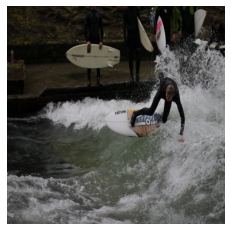

In [29]:
save_every = 1000
show_every = 500
n_train_batches = len(train)//BATCH_SIZE
n_val_batches = len(val)//BATCH_SIZE

for epoch in range(1, 3+1):
    print('_'*5, 'Epoch:', epoch, '_'*5)
    print('Train')
    for i_step, (images, captions) in enumerate(train_loader):
        decoder.zero_grad()
        encoder.zero_grad()
        encoder.train()
        decoder.train()

        captions_target = captions.to(device)
        captions_train = captions[:, :-1].to(device)
        images = images.to(device)
        features = encoder(images)
        outputs = decoder(features, captions_train)

        loss = criterion(outputs.view(-1, vocab_size), captions_target.contiguous().view(-1))
        loss.backward()
        decoder_optimizer.step()
        encoder_optimizer.step()
        
        losses.append(loss.item())
        
        print(f'\rDone: {i_step/n_train_batches*100: <4.2f}%, loss: {loss.item():.4f}', end='')
        
        if (i_step + 1) % show_every == 0:
            print()
            make_prediction(train, encoder, decoder)
            print()
            
        if (i_step + 1) % save_every == 0:
            print("Saved!")
            decoder.save_weights(epoch, i_step//save_every)
            encoder.save_weights(epoch, i_step//save_every)
    print('\nValidation')
    for i_step, (val_images, val_captions) in enumerate(val_loader):
        # - - - Validate - - -
        with torch.no_grad():
            encoder.eval()
            decoder.eval()
            captions_target = val_captions.to(device)
            captions_train = val_captions[:, :-1].to(device)
            val_images = val_images.to(device)
            features = encoder(val_images)
            outputs = decoder(features, captions_train)
            val_loss = criterion(outputs.view(-1, vocab_size), captions_target.contiguous().view(-1))

        if (i_step + 1) % show_every == 0:
            print()
            make_prediction(val, encoder, decoder)
            print()
        
        val_losses.append(val_loss.item())
        print(f'\rDone: {i_step/n_val_batches*100: <4.2f}%, validation loss: {val_loss.item():.4f}', end='')

    np.save('losses', np.array(losses))
    np.save('val_losses', np.array(val_losses))
    print(f'\nAverage validation loss: {np.mean(val_losses)}')

Внизу можно увидеть примеры подписей, пока что без картинок, к сожалению. `GT` - ground truth.

In [0]:
# !cp models/encoder-1-4000.pth drive/My\ Drive

In [0]:
# !cp models/decoder-1-4000.pth drive/My\ Drive